In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report


In [6]:
# Load the dataset
dataset = pd.read_csv(r'C:\Users\Deepu\OneDrive\Desktop\Capstone1\reddit_preprocessing.csv')

In [7]:
# Drop rows with NaN values in 'clean_comment'
cleaned_dataset = dataset.dropna()

# Separate features and target
X_cleaned = cleaned_dataset['clean_comment']
y_cleaned = cleaned_dataset['category']

In [ ]:
# Split the cleaned data into train and test sets (80-20 split)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [9]:
# Apply TfidfVectorizer with trigram setting and max_features=10000
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_tfidf_cleaned = tfidf.fit_transform(X_train_cleaned)
X_test_tfidf_cleaned = tfidf.transform(X_test_cleaned)

In [10]:
# Define the base classifiers

#Base Learner
lgbm = LGBMClassifier(
    objective="multiclass",  
    num_class=3,
    n_estimators=200, 
    learning_rate=0.1,
    max_depth=15,
    random_state=42
)

# Base Learner
lr = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42
)

# Meta learner 
knn = KNeighborsClassifier(n_neighbors=5)

In [11]:
# Create the stacking classifier
# Define estimators (base models)
estimators = [
    ('lgbm', lgbm),
    ('lr', lr),
    ('knn', knn)
]

# Define the final estimator (meta-model)
final_estimator = LogisticRegression(max_iter=1000)

# Create the StackingClassifier
stacking_clf = StackingClassifier(
    estimators = [
    ('lgbm', lgbm),
    ('lr', lr)
],
    final_estimator=knn   ,
    cv=5,  # 5-fold cross-validation
    stack_method='auto',  # Use predict_proba when available, otherwise predict
    n_jobs=-1  # Use all available cores
)

In [12]:
# Fit the stacking classifier on the training data
print("Training the stacking classifier...")
stacking_clf.fit(X_train_tfidf_cleaned, y_train_cleaned)
print("Training complete!")

Training the stacking classifier...
Training complete!


In [13]:
# Make predictions on the test set
y_pred = stacking_clf.predict(X_test_tfidf_cleaned)

# Print classification report
print("Classification Report for Stacking Classifier:")
print(classification_report(y_test_cleaned, y_pred))

c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

          -1       0.84      0.82      0.83      1581
           0       0.93      0.97      0.95      2617
           1       0.92      0.90      0.91      3152

    accuracy                           0.91      7350
   macro avg       0.90      0.90      0.90      7350
weighted avg       0.91      0.91      0.91      7350



In [14]:
# For comparison, let's train and evaluate each base model individually

# Function to train, predict and evaluate a classifier
def evaluate_model(clf, name):
    print(f"Training {name}...")
    clf.fit(X_train_tfidf_cleaned, y_train_cleaned)
    y_pred = clf.predict(X_test_tfidf_cleaned)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test_cleaned, y_pred))
    return y_pred

# Evaluate each base model
lgbm_pred = evaluate_model(lgbm, "LightGBM")
lr_pred = evaluate_model(lr, "Logistic Regression")
knn_pred = evaluate_model(knn, "K-Nearest Neighbors")

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198915
[LightGBM] [Info] Number of data points in the train set: 29400, number of used features: 7117
[LightGBM] [Info] Start training from score -1.483825
[LightGBM] [Info] Start training from score -1.066975
[LightGBM] [Info] Start training from score -0.845870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report for LightGBM:
              precision    recall  f1-score   support

          -1       0.88      0.74      0.80      1581
           0       0.88      0.98      0.93      2617
           1       0.91      0.90      0.90      3152

    accuracy                           0.89      7350
   macro avg       0.89      0.87      0.88      7350
weighted avg       0.89      0.89      0.89      7350

Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       0.85      0.67      0.75      1581
           0       0.85      0.95      0.90      2617
           1       0.88      0.89      0.88      3152

    accuracy                           0.86      7350
   macro avg       0.86      0.84      0.84      7350
weighted avg       0.86      0.86      0.86      7350

Training K-Nearest Neighbors...

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-sco

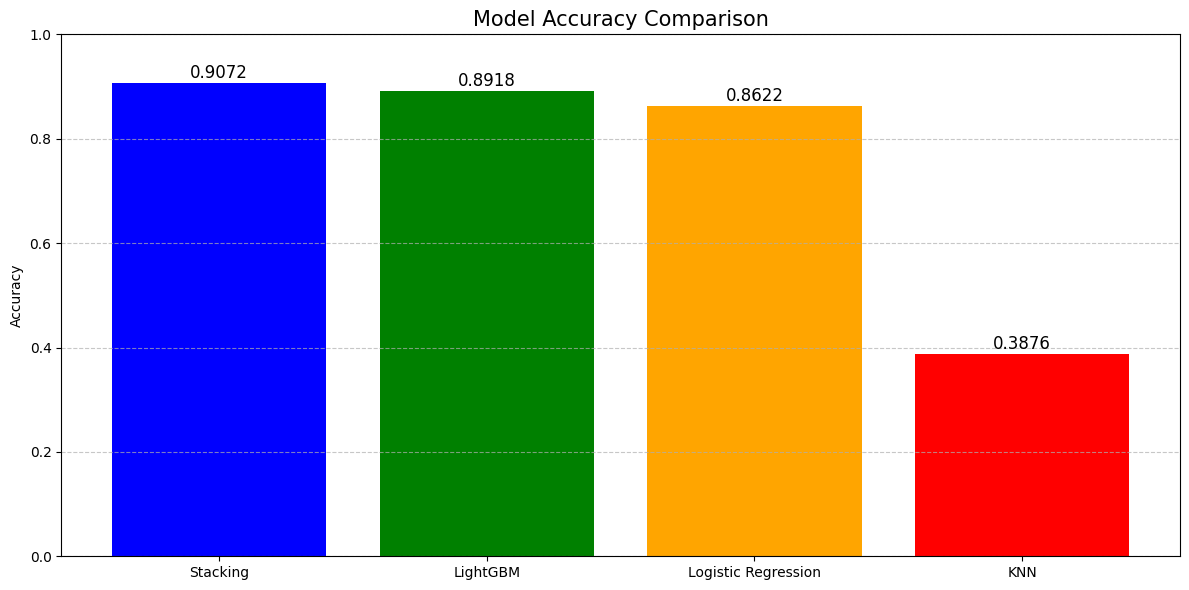

,Model,Accuracy
0,Stacking,0.907211
1,LightGBM,0.891837
2,Logistic Regression,0.862177
3,KNN,0.387619


In [15]:
# Compare model accuracies
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Calculate accuracies
accuracies = {
    'Stacking': accuracy_score(y_test_cleaned, y_pred),
    'LightGBM': accuracy_score(y_test_cleaned, lgbm_pred),
    'Logistic Regression': accuracy_score(y_test_cleaned, lr_pred),
    'KNN': accuracy_score(y_test_cleaned, knn_pred)
}

# Create a bar chart
plt.figure(figsize=(12, 6))
models = list(accuracies.keys())
acc_values = list(accuracies.values())

bars = plt.bar(models, acc_values, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Accuracy Comparison', fontsize=15)
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Print accuracies as a table
acc_df = pd.DataFrame({'Model': models, 'Accuracy': acc_values})
acc_df

Top 20 most important features:


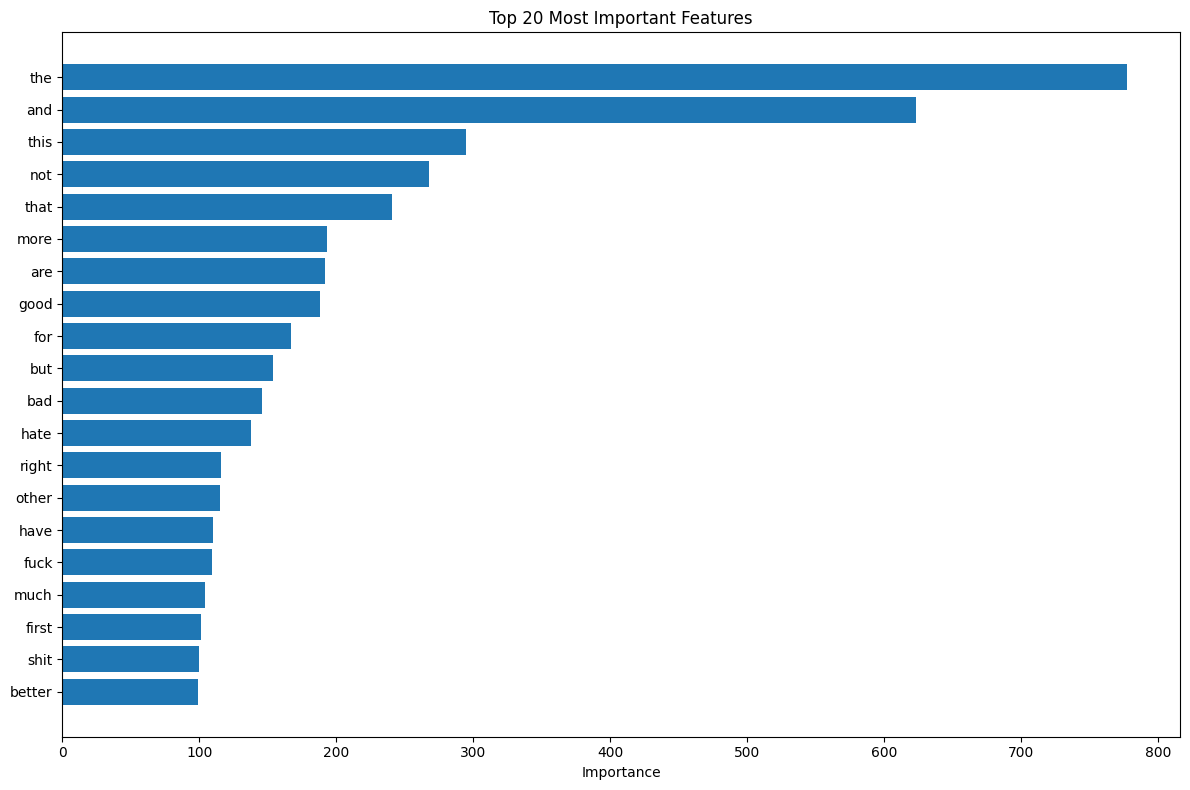

In [16]:
# Get feature importance from the LightGBM model (one of our base models)
# This can help us understand which features are most important for classification

# Get feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Get feature importances from LightGBM
importances = lgbm.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 most important features
print("Top 20 most important features:")
feature_importance_df.head(20)

# Plot the top 20 features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df.head(20)['Feature'][::-1], 
         feature_importance_df.head(20)['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

In [17]:
# Save the trained models for future use
import pickle
import os

# Create a models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the stacking classifier
with open('models/stacking_classifier.pkl', 'wb') as f:
    pickle.dump(stacking_clf, f)

# Save the TF-IDF vectorizer (needed for preprocessing new data)
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Models saved successfully!")

Models saved successfully!


# Conclusion

In this notebook, we've created a stacking ensemble model that combines the strengths of three different classifiers:

1. **LightGBM** - A gradient boosting framework that uses tree-based learning algorithms
2. **Logistic Regression** - A linear model for classification
3. **K-Nearest Neighbors** - A non-parametric method for classification

The stacking approach allows us to leverage the strengths of each individual model while mitigating their weaknesses. By using a meta-classifier (LogisticRegression), we can intelligently combine the predictions of the base models to achieve better overall performance.

The comparison between the stacking ensemble and individual models shows whether the ensemble approach provides meaningful improvement over the base models.

# Stacking Ensemble for Text Classification

Stacking is an ensemble learning technique that combines multiple classification models via a meta-classifier. The base models are trained on the complete training set, then the meta-model is trained on the outputs of the base models.

This notebook implements:
1. TF-IDF feature extraction with trigrams
2. Three base classifiers (LightGBM, LogisticRegression, KNN)
3. A meta-classifier (LogisticRegression) to combine predictions